# 호텔 예약 데이터를 통한 예약 취소율 개선 방안 아이디어

## 1. 호텔 예약 데이터 정리

In [11]:
# 호텔 데이터 불러오기
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

df = pd.read_csv('data/hotel_data_modified.csv')
df.head()
#df[['country']]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,NaN,NaN,0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,NaN,NaN,0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,NaN,NaN,0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,304.0,NaN,0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,240.0,NaN,0,0,1,Check-Out,2015-07-03


### 1) 결측치 확인 및 수정

In [7]:
# 결측치 확인
df.shape
df.isna().sum()

df['company'] = df['company'].fillna(0) # company 칼럼 결측치 대체
children_mean = df['children'].mean() 
df['children'] = df['children'].fillna(children_mean) # chlidren 칼럼 결측치 children 평균값으로 대체
df['agent'] = df['agent'].fillna(0) # agent 결측치 대체
df['country'] = df['country'].fillna('Unknown') # country 컬럼 결측치 Unknown으로 대체

In [62]:
df.info()
# df.isna().sum()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,C,C,3,NaN,NaN,0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,C,C,4,NaN,NaN,0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,A,C,0,NaN,NaN,0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,A,A,0,304.0,NaN,0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,A,0,240.0,NaN,0,0,1,Check-Out,2015-07-03


### 2) 데이터 확인
- 호텔 예약자(어른, 어린이, 아기) 모두 0명인 예약은 없는것으로 간주, 필터링 후 제거.

In [24]:
 # 호텔 예약자(어른, 어린이, 아기) 모두 0명인 예약은 없는것으로 간주, 필터링 후 제거.

pd.set_option('display.max_columns', None)
filter = (df.children == 0) & (df.adults == 0) & (df.babies == 0)
# df[filter]
df = df[~filter]
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_guests,lead_time_bin
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,NaN,NaN,0,0,0,Check-Out,2015-07-01,2.0,181-365일
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,NaN,NaN,0,0,0,Check-Out,2015-07-01,2.0,731일+
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,NaN,NaN,0,0,0,Check-Out,2015-07-02,1.0,0-7일
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,304.0,NaN,0,0,0,Check-Out,2015-07-02,1.0,8-14일
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,240.0,NaN,0,0,1,Check-Out,2015-07-03,2.0,8-14일


## 2. 전체 예약 취소 비율


In [17]:
from matplotlib import font_manager, rc

# 1. 한글 폰트 경로 설정 (Windows 기본: 맑은 고딕)
font_path = "C:/Windows/Fonts/malgun.ttf"  
font_name = font_manager.FontProperties(fname=font_path).get_name()

# 2. Matplotlib 전역 설정
rc('font', family=font_name)

# 3. 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

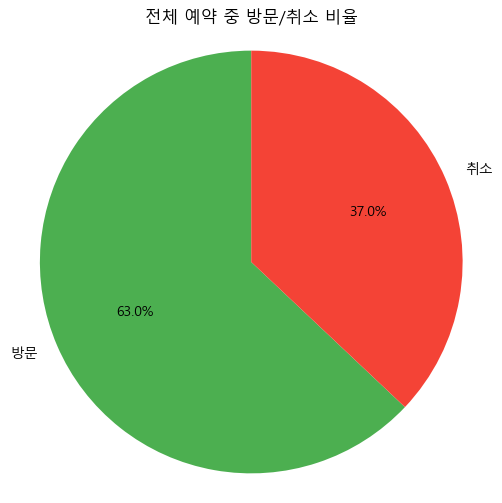

In [18]:
# 예약 취소 여부 집계 (0=방문, 1=취소)
cancel_counts = df['is_canceled'].value_counts()

# 파이 차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(
    cancel_counts,
    labels=['방문', '취소'],   # 0, 1 순서
    autopct='%1.1f%%',                     # 퍼센트 표시
    startangle=90,                         # 시작 각도
    colors=['#4CAF50', '#F44336']          # 초록(방문), 빨강(취소)
)
plt.title('전체 예약 중 방문/취소 비율')
plt.axis('equal')  # 원형 유지
plt.show()

 전체 예약 중 취소율은 **37%** 에 달한다.
 - 이하 각 요소별 취소율을 확인하고 평균 취소율 **37%** 를 웃도는 데이터 위주로 개선 방안을 확인해 봐야함.

## 3. 각 요소별 예약 취소 관련 추이

### 1) 국가별 예약 취소 비율

In [19]:
# 국가별 전체 예약 수와 취소 예약 수 집계
country_cancel_stats = (
    df.groupby('country')['is_canceled']
    .agg(['mean', 'count'])  # mean = 취소율(비율), count = 총 예약 수
    .reset_index()
)
country_cancel_stats.columns = ['country', 'cancellation_rate', 'total_bookings']  # 컬럼 이름 정리
country_cancel_stats['cancellation_rate'] = country_cancel_stats['cancellation_rate'] * 100 # 퍼센트로 변환
country_cancel_stats.head(7)

,country,cancellation_rate,total_bookings
0,ABW,0.000000,2
1,AGO,56.629834,362
2,AIA,0.000000,1
3,ALB,16.666667,12
4,AND,71.428571,7
5,ARE,84.313725,51
6,ARG,25.233645,214


국가별 전체 예약 수와 취소 예약 수 집계

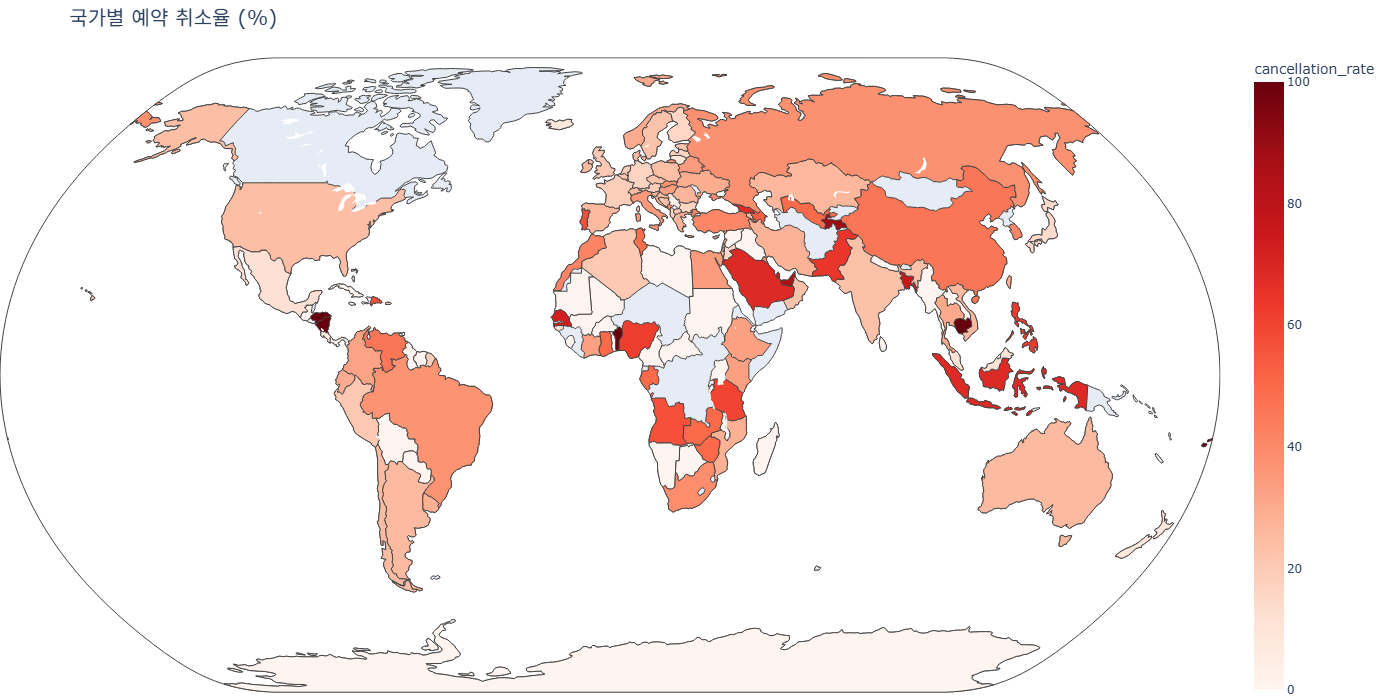

In [21]:
import plotly.express as px

fig = px.choropleth(
    country_cancel_stats,
    locations='country',                  # ISO-3 국가 코드
    color='cancellation_rate',            # 색상 기준: 취소율
    hover_name='country',
    hover_data=['cancellation_rate', 'total_bookings'],
    color_continuous_scale='Reds',        
    projection='natural earth',
    title='국가별 예약 취소율 (%)'
)

# 지도 크기 키우기
fig.update_layout(
    width=1200,
    height=700,
    title_font_size=20,
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()

### 2) 월별 예약 취소 비율

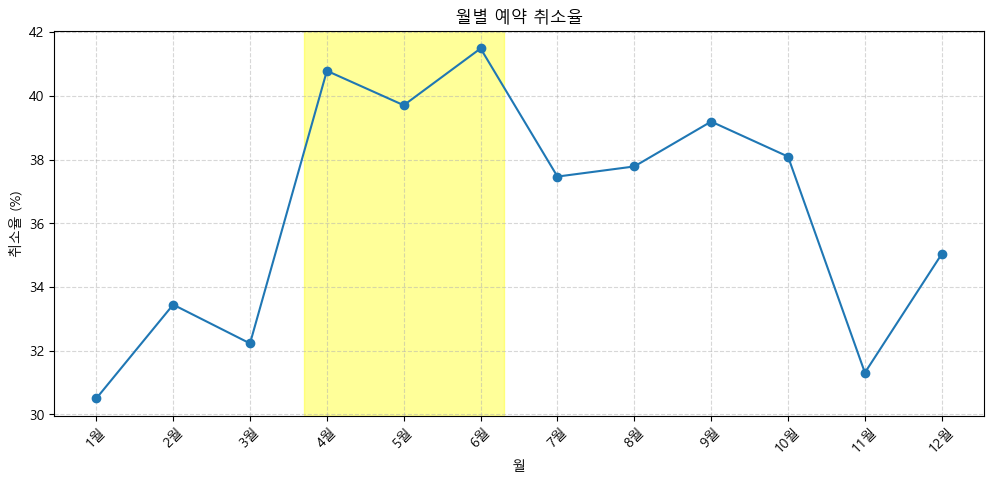

In [31]:
month_kor_map = {
    'January': '1월',
    'February': '2월',
    'March': '3월',
    'April': '4월',
    'May': '5월',
    'June': '6월',
    'July': '7월',
    'August': '8월',
    'September': '9월',
    'October': '10월',
    'November': '11월',
    'December': '12월'
}

month_order = [
    'January','February','March','April','May','June',
    'July','August','September','October','November','December'
]

monthly_cancel_ratio = (
    df.groupby('arrival_date_month')['is_canceled']
    .mean() * 100
).reindex(month_order).dropna()

monthly_cancel_ratio.index = monthly_cancel_ratio.index.map(month_kor_map)

plt.figure(figsize=(12, 5))
plt.plot(monthly_cancel_ratio.index, monthly_cancel_ratio.values, marker='o')
plt.title('월별 예약 취소율')
plt.xlabel('월')
plt.ylabel('취소율 (%)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# 🔸 4월~6월 구간 강조
highlight_start = '4월'
highlight_end = '6월'
x_positions = monthly_cancel_ratio.index.tolist()

# 시작~끝 인덱스 찾기
start_idx = x_positions.index(highlight_start)
end_idx = x_positions.index(highlight_end)

# x축 영역 강조 (색, 투명도 설정)
plt.axvspan(start_idx - 0.3, end_idx + 0.3, color='yellow', alpha=0.4)
plt.show()

예약 취소율이 급격하게 높아지는 때는 4~6월로 , 날이 풀려 야외 활동이 많아지는 늦봄에서 성수기 휴가철을 바로 앞둔 초여름까지의 시기로 파악됨.
- 호텔 자체적인 행사를 기획하여 취소율을 낮추고 방문을 유도하거나, 예약취소시 취소 수수료를 크게 부여하여 취소율을 낮추는 방법을 고민해볼 수 있음.

### 3) 리드 타임 별 예약 취소 비율

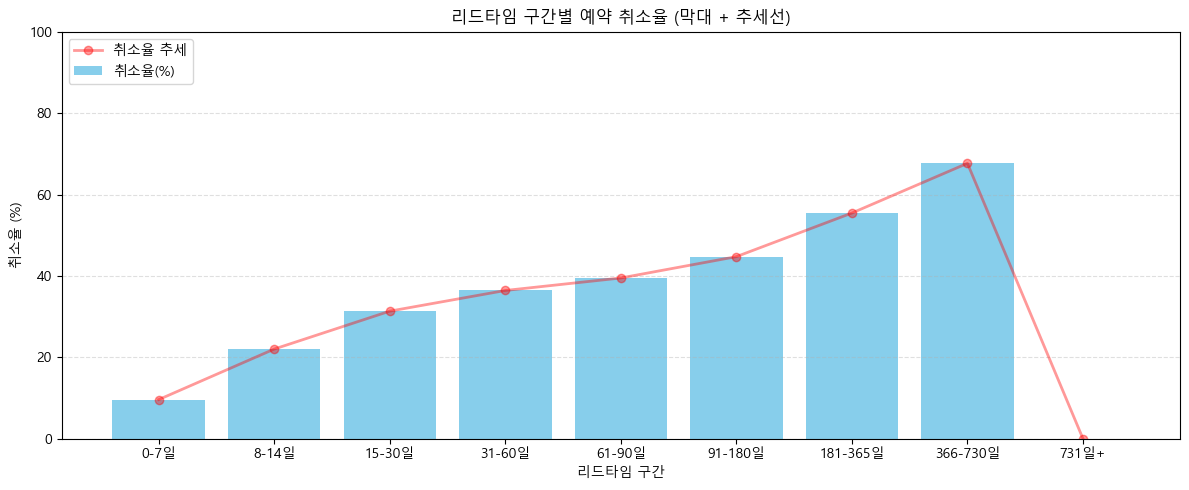

In [26]:
# 1) 리드타임을 해석하기 쉬운 구간으로 나누기
bins = [0, 7, 14, 30, 60, 90, 180, 365, 730, np.inf]
labels = ['0-7일','8-14일','15-30일','31-60일','61-90일','91-180일','181-365일','366-730일','731일+']
df['lead_time_bin'] = pd.cut(df['lead_time'], bins=bins, labels=labels, right=True, include_lowest=True)

# 2) 각 구간의 취소율(%) 계산
lead_bin_cancel = (
    df.groupby('lead_time_bin')['is_canceled']
      .mean()
      .mul(100)
      .reset_index(name='cancel_rate')
)

# 시각화: 막대 + 라인
fig, ax1 = plt.subplots(figsize=(12, 5))

# 막대그래프
bars = ax1.bar(lead_bin_cancel['lead_time_bin'], lead_bin_cancel['cancel_rate'], color='skyblue', label='취소율(%)')
ax1.set_xlabel('리드타임 구간')
ax1.set_ylabel('취소율 (%)')
ax1.set_title('리드타임 구간별 예약 취소율 (막대 + 추세선)')
ax1.set_ylim(0, 100)
plt.xticks(rotation=0)
ax1.grid(axis='y', linestyle='--', alpha=0.4)

# 라인 그래프 (2번째 y축을 쓰지 않고, 같은 축에 얹기)
ax1.plot(lead_bin_cancel['lead_time_bin'], lead_bin_cancel['cancel_rate'],
         color='red', alpha=0.4, marker='o', linewidth=2, label='취소율 추세')

# 범례 표시
ax1.legend(loc='upper left')

plt.tight_layout()
plt.show()


오래전에 예약( 3개월 ~ 2년 )한 고객일수록 취소율이 높은것으로 확인됨.
- 예약 후 시간 경과에 따른 취소 수수료 구간을 만들어 예약 대기 기간이 길수록 수수료를 높이거나, 일정 기간(ex. 6개월)이내의 예약만 가능하게끔 예약 제도의 개선이 필요할 것으로 판단됨.

### 4) 예약자 수에 따른 예약 취소 비율

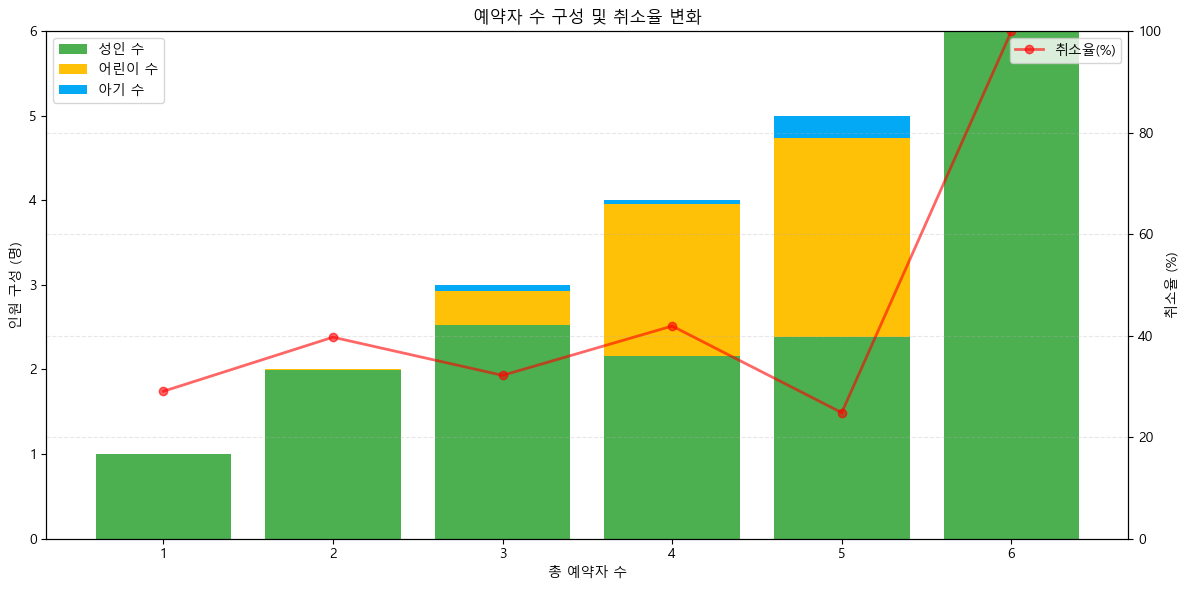

In [27]:

# 총 방문자 수
df['total_guests'] = df['adults'] + df['children'] + df['babies']

# 총 8명 이하만 사용 (극단값 제거)
df_filtered = df[(df['total_guests'] <= 8) & (df['total_guests'] >= 1)]

# 그룹별 평균 취소율 & 평균 인원 구성 계산
group_stats = df_filtered.groupby('total_guests', observed=False).agg({
    'is_canceled': 'mean',
    'adults': 'mean',
    'children': 'mean',
    'babies': 'mean'
}).reset_index()

group_stats['cancel_rate'] = group_stats['is_canceled'] * 100

# 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))

x = group_stats['total_guests']
adults = group_stats['adults']
children = group_stats['children']
babies = group_stats['babies']
cancel_rate = group_stats['cancel_rate']

# 누적 막대그래프: 어른 + 어린이 + 아기
bar1 = ax1.bar(x, adults, color='#4CAF50', label='성인 수')
bar2 = ax1.bar(x, children, bottom=adults, color='#FFC107', label='어린이 수')
bar3 = ax1.bar(x, babies, bottom=adults+children, color='#03A9F4', label='아기 수')

ax1.set_xlabel('총 예약자 수')
ax1.set_ylabel('인원 구성 (명)')
ax1.set_xticks(x)
ax1.set_title('예약자 수 구성 및 취소율 변화')

# 취소율 라인 (두 번째 y축)
ax2 = ax1.twinx()
ax2.plot(x, cancel_rate, color='red', marker='o', alpha=0.6, linewidth=2, label='취소율(%)')
ax2.set_ylabel('취소율 (%)')
ax2.set_ylim(0, 100)

# 범례 처리
bars_legend = ax1.legend(loc='upper left')
line_legend = ax2.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

어린이와 아이가 포함된 가족의 예약 취소비율은 낮게 확인되나, 성인 5명 이상의 예약건은 취소율이 매우 높게 확인됨.


### 5) 재방문 고객과 신규 고객의 호텔 유형별 예약 취소 비율

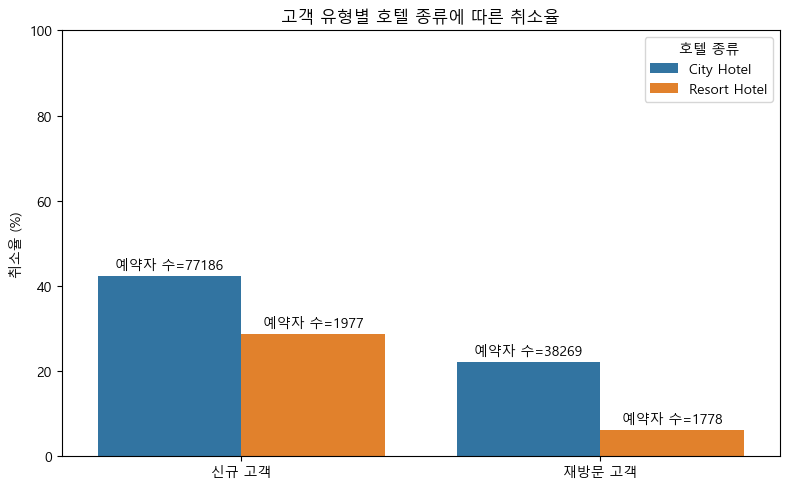

In [28]:

# 1) 그룹별 취소율(%) + 예약 건수(count)
grouped = (
    df.groupby(['is_repeated_guest', 'hotel'], observed=False)['is_canceled']
      .agg(['mean', 'count'])
      .reset_index()
)
grouped['cancel_rate'] = grouped['mean'] * 100
grouped['group'] = grouped['is_repeated_guest'].map({0: '신규 고객', 1: '재방문 고객'})

# 2) 막대가 그려질 순서 고정
groups_order = ['신규 고객', '재방문 고객']
hue_order = sorted(df['hotel'].dropna().unique().tolist())  # 필요시 수동 지정 가능: ['City Hotel', 'Resort Hotel']

# 3) 시각화
plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=grouped,
    x='group', y='cancel_rate', hue='hotel',
    order=groups_order, hue_order=hue_order
)
plt.title('고객 유형별 호텔 종류에 따른 취소율')
plt.ylabel('취소율 (%)')
plt.xlabel('')
plt.legend(title='호텔 종류')
plt.ylim(0, 100)  # 라벨 올라갈 여유
plt.tight_layout()

# 4) 막대 순서에 맞춰 count 라벨 부여
#    (group, hotel) -> count 매핑을 만든 뒤, order/hue_order로 순회하며 라벨 리스트 생성
count_map = grouped.set_index(['group', 'hotel'])['count']
counts_in_order = []
for g in groups_order:
    for h in hue_order:
        counts_in_order.append(count_map.get((g, h), 0))

for p, n in zip(ax.patches, counts_in_order):
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2,
        height + 1,                # 막대 위 1만큼 띄워서
        f'예약자 수={n}',
        ha='center', va='bottom', fontsize=10
    )

plt.show()


City Hotel을 예약한 신규 고객의 취소율이 평균 취소율(37%)을 크게 웃돌고 있다.
- City Hotel 의 신규 고객의 예약 취소율을 줄이기 위해, 첫 방문 신규 고객을 대상으로 하는 프로모션을 기획하는 방법도 좋을듯 함.

### 6) 예약 변경 횟수별 예약 취소 비율

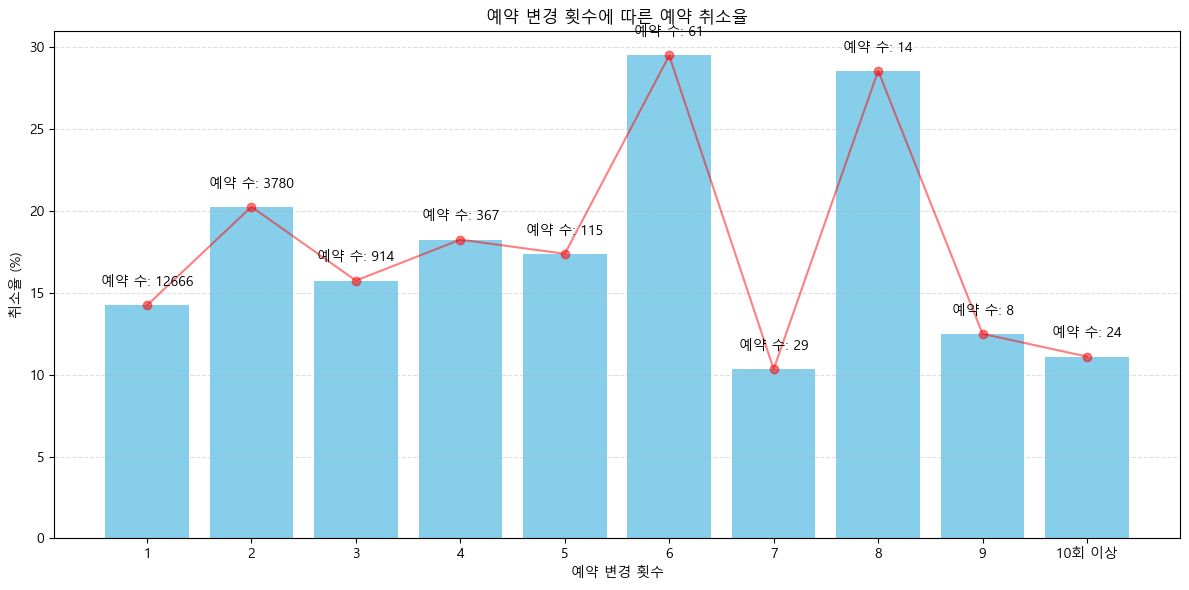

In [36]:
# 0회 변경 제외
df_changes = df[df['booking_changes'] > 0]

# 변경 횟수별 취소율 및 예약 수 계산
changes_cancel_stats = (
    df_changes.groupby('booking_changes', observed=False)['is_canceled']
        .agg(['mean', 'count'])
        .reset_index()
)
changes_cancel_stats['cancel_rate'] = changes_cancel_stats['mean'] * 100

# 10회 이상 변경 그룹을 묶기
changes_cancel_stats['group'] = changes_cancel_stats['booking_changes'].apply(
    lambda x: '10회 이상' if x >= 10 else str(x)
)

plot_df = changes_cancel_stats.groupby('group').agg({
    'cancel_rate': 'mean',
    'count': 'sum'
}).reset_index()

# x축 정렬 순서 지정
group_order = [str(i) for i in range(0, 10)] + ['10회 이상']
plot_df['group'] = pd.Categorical(plot_df['group'], categories=group_order, ordered=True)
plot_df = plot_df.sort_values('group')

plt.figure(figsize=(12,6))

bars = plt.bar(plot_df['group'], plot_df['cancel_rate'], color='skyblue')
plt.plot(plot_df['group'], plot_df['cancel_rate'], color='red', alpha=0.5, marker='o')

plt.title('예약 변경 횟수에 따른 예약 취소율')
plt.xlabel('예약 변경 횟수')
plt.ylabel('취소율 (%)')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# 막대 위에 예약 수 표시
for bar, n in zip(bars, plot_df['count']):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 1,
        f'예약 수: {n}',
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()


### 7) 과거 취소 회수에 따른 예약 취소 비율

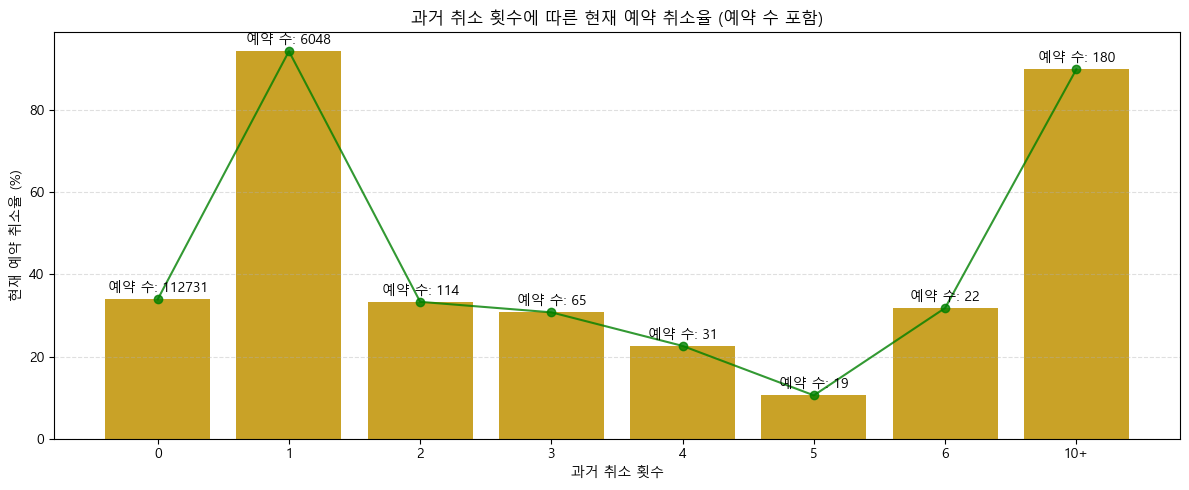

In [30]:
cancel_by_prev = (
    df.groupby('previous_cancellations', observed=False)['is_canceled']
      .agg(['mean', 'count'])
      .reset_index()
)
cancel_by_prev['cancel_rate'] = cancel_by_prev['mean'] * 100
cancel_by_prev['group'] = cancel_by_prev['previous_cancellations'].apply(lambda x: '10+' if x >= 10 else str(x))

# 그룹화 (10+ 합치기)
plot_df = cancel_by_prev.groupby('group').agg({'cancel_rate':'mean','count':'sum'}).reset_index()

# x축 정렬 순서 명시
group_order = [str(i) for i in range(0, 10)] + ['10+']
plot_df['group'] = pd.Categorical(plot_df['group'], categories=group_order, ordered=True)
plot_df = plot_df.sort_values('group')

# 시각화
plt.figure(figsize=(12,5))
bars = plt.bar(plot_df['group'], plot_df['cancel_rate'], color='#C9A227')
plt.plot(plot_df['group'], plot_df['cancel_rate'], color='green', alpha=0.8, marker='o')

plt.title('과거 취소 횟수에 따른 현재 예약 취소율 (예약 수 포함)')
plt.xlabel('과거 취소 횟수')
plt.ylabel('현재 예약 취소율 (%)')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# 막대 위에 예약 수 표시
for bar, n in zip(bars, plot_df['count']):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 1,
        f'예약 수: {n}',
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()

과거 취소 횟수가 많은 고객을 특정하여 블랙컨슈머로 지정 및 확인하려 하였으나 예약자 고객의 ID 데이터가 확인되지 않아 불가능. 
- 과거 취소 횟수가 10회 이상인 고객들의 취소율이 매우 높은것으로 확인됨.
- 취소 횟수가 n회 이상인 고객들의 구간을 만들어 취소 페널티를 적용하는 환불 운영 정책이 필요할 것으로 보임.